<center><h2><b>MINI - PROJECT </b></h2></center><center><h3><b>MSDS 6371 - 403</b></h3></center><center><h3><b>Data Mining</b></h3></center>

<h4><b>Team Members:</b></h4>
<ul>
  <li>Lisa Mendez</li>
  <li>Brandon Lawrence</li>
  <li>Dominique Edwards</li>
  <li>Mariana Llamas-Cendon</li>
</ul>

<h2><b><center> SVM and Logistic Regression Modeling</center></b></h2> 



<h3><b>[50 points]</b>

<i>Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use
80/20 training/testing split for your data).</i>
<i><b>Adjust parameters of the models to make them
more accurate.</b></i>

<i>If your dataset size requires the use of stochastic gradient descent, then
linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic
regression and linear support vector machines. For many problems, SGD will be required in
order to train the SVM model in a reasonable timeframe.</i></h3> 



#### For this project we are using the cleaned version of the data set ('accident.xlsx') we have used for Project1, in which those attributes that we consider not useful for our analysis were already removed during Project1. 

In [45]:
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

import pandas as pd
from pandas import DataFrame
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline


In [46]:
df_accident = pd.read_excel('accident_clean.xlsx')
df_accident.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,...,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER,FATALS,DRUNK_DR,DATETIME
0,1,10001,1,1,0,0,0,1,1,127.0,...,0.0,1.0,1.0,0,4.0,2.0,1.0,1,1,2015-01-01
1,1,10002,1,1,0,0,0,1,1,83.0,...,0.0,1.0,1.0,0,3.0,2.0,10.0,1,0,2015-01-01
2,1,10003,1,1,0,0,0,2,2,11.0,...,0.0,1.0,1.0,0,4.0,2.0,1.0,1,1,2015-01-01
3,1,10004,1,1,0,0,0,1,1,45.0,...,0.0,1.0,1.0,0,4.0,2.0,10.0,1,1,2015-01-04
4,1,10005,2,2,0,0,0,2,2,45.0,...,0.0,2.0,3.0,0,1.0,1.0,1.0,1,0,2015-01-07


In [47]:
print ('The number of rows is       ', df_accident.shape[0])
print ('The number of attributes is ', df_accident.shape[1])

The number of rows is        30828
The number of attributes is  33


Some of the attributes from the dataframe called "df_accident" as shown in the previous cell using .info( ) need to be coerced from their current type to an object because due to their nature, which will be explained in the next paragraph they will be used just as a reference but do not have any impact in the analysis.
Those attributes are:

- **ST_CASE** *--which appears continuous (int64) but refers to a unique identifier for each report of an accident;*
- **DAY_WEEK** *--which also appears as continuous, should be a discrete variable with values ranging from 1 (Sunday) to 7 (Saturday) that identifies the day of the week in which a particular accident took place;*
- **HOUR** *-- which also appears as continuous, we decided that since we couldn't correctly coerce it into an appropriate time format, it could be helpful as an object with values ranging from 0 to 23 as a reference in case we would need it;*
- **COUNTY** *--which appears as a float (float64), represents the identifying codes of each of the counties where an accident took place, therefore it could be more useful as an object. *

In the next cell, the aforementioned attributes are coerced, as previously mentioned, from their current types to objects. We haven't yet decided at this point if they are worth keeping for this project or not. 

In [48]:
# Coerce ST_CASE, COUNTY, DAY_WEEK, HOUR from dtype int64 to object as the values are not numbers but strings
df_accident[['STATE', 'ST_CASE', 'COUNTY', 'DAY_WEEK', 'HOUR']] = df_accident[['STATE', 'ST_CASE', 'COUNTY', 'DAY_WEEK', 'HOUR']].astype(object)

Based on the previous knowledge--from Project1--we have on the data set, in which missing values were present only in those categorical attributes, will be wise to corroborate that no missing values are present in those continuous variables such as VE_TOTAL, VE_FORMS, PVH_INVL, PEDS, PERNOTMVIT, PERSONS, TWAY_ID, LATITUDE, LONGITUDE, FATALS, DRUNK_DR. 

In [49]:
# Check for missing values, we expect those to be in the categorical variables but not the continuous ones
df_accident.isnull().any()

STATE         False
ST_CASE       False
VE_TOTAL      False
VE_FORMS      False
PVH_INVL      False
PEDS          False
PERNOTMVIT    False
PERMVIT       False
PERSONS       False
COUNTY         True
DAY_WEEK      False
HOUR           True
NHS            True
RUR_URB        True
FUNC_SYS       True
RD_OWNER       True
ROUTE          True
TWAY_ID       False
LATITUDE       True
LONGITUD       True
SP_JUR         True
HARM_EV        True
MAN_COLL       True
RELJCT1        True
RELJCT2        True
TYP_INT        True
WRK_ZONE      False
REL_ROAD       True
LGT_COND       True
WEATHER        True
FATALS        False
DRUNK_DR      False
DATETIME      False
dtype: bool

Judging from the results provided in the above cell, our recollection about the original data was right on track: no continuous variables have missing values, but most of categorical variables, except for WRK_ZONE do contain NaNs.

Since according to <a href="https://pandas.pydata.org/pandas-docs/stable/missing_data.html">Pandas documentation</a> for missing values, Pandas treats NaNs as zero and we don't know the reason why those values are missing whether because they are really missing, their value should be zero or they were just wrongly recorded, we decided that the best route of action was to get rid of them. It is important to mention that the decision was also influenced by the fact that some of those categorical attributes are binary or have several levels, therefore it would be arbitrary to convert missing values to 0 or any other value. 

So in the following two cells, we will get rid of missing values from the whole data set, and then check that the missing values are in fact out. 

Now, remember that missing values are present only on categorical variables, therefore imputation cannot be performed.

In [50]:
# Drop missing values from data set
df_accident.dropna(inplace = True)

In [51]:
# Check that missing values are in fact gone
df_accident.isnull().any()

STATE         False
ST_CASE       False
VE_TOTAL      False
VE_FORMS      False
PVH_INVL      False
PEDS          False
PERNOTMVIT    False
PERMVIT       False
PERSONS       False
COUNTY        False
DAY_WEEK      False
HOUR          False
NHS           False
RUR_URB       False
FUNC_SYS      False
RD_OWNER      False
ROUTE         False
TWAY_ID       False
LATITUDE      False
LONGITUD      False
SP_JUR        False
HARM_EV       False
MAN_COLL      False
RELJCT1       False
RELJCT2       False
TYP_INT       False
WRK_ZONE      False
REL_ROAD      False
LGT_COND      False
WEATHER       False
FATALS        False
DRUNK_DR      False
DATETIME      False
dtype: bool

The number of missing values eliminated was 9034, which accounts for about 1/3 of the data. 

In [52]:
print ('The number of rows is       ', df_accident.shape[0])
print ('The number of attributes is ', df_accident.shape[1])

The number of rows is        21794
The number of attributes is  33


The **STATE** attribute, which is a categorical, contained 56 levels (from 1 to 56): each one representing a state plus territories such as: 
- *American Samoa*
- *D.C*
- *Guam*
- *Puerto Rico*
- *Virgin Islands*

We decided to keep our analysis within the continental USA, including Hawaii and Alaska, and deleting those observations related to the rest of the aforementioned territories. 

In [54]:
# STATE attribute has 56 values, since it includes American Samoa, Puerto Rico, Guam, D.C. and the Virgin Islands. 
# In this data set we'll focus on only continental USA including Alaska and Hawaii.
df_accident = df_accident[df_accident.STATE != 3] # Delete rows that pertain to American Samoa
df_accident = df_accident[df_accident.STATE != 11] # Delete rows that pertian to D.C.
df_accident = df_accident[df_accident.STATE != 14] # Delete rows that contain Guam
df_accident = df_accident[df_accident.STATE != 43] # Delete rows that pertain to Puerto Rico
df_accident = df_accident[df_accident.STATE != 52] # Delete rows that pertain to Virgin Islands

For an unknown reason, the index of the whole data set was set to start at 0 as opposed to 1, so it was necessary for our own understanding to switch it back to starting at 1. 

In [55]:
#change index to start at 1 not 0
df_accident.index = np.arange(1, len(df_accident)+1)

Deleting the territories slightly reduced the number of observation in our data set from 21794 to 21773. Only 21 instances were removed. The fact that so few instances were removed indicated that deleting the territories from the dataframe was a good choice because they were not representative of the data. 

In [56]:
print ('The number of rows is       ', df_accident.shape[0])
print ('The number of attributes is ', df_accident.shape[1])

The number of rows is        21773
The number of attributes is  33


Considering that **STATE** attribute still contains 51 levels, turning it into a dummy variable will unnecesarily complicate its interpretation. Therefore, instead we decided to create a new attribute named **REGION** that will separate the values from **STATE** into four regions: West (1), Midwest (2), South (3) and Northeast (4), following how they are divided in <a href="https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States">Wikipedia.</a>
This way we can still use **STATE** as a reference or include it in other analysis later on, whereas interpreting **REGION** will not turn out to be a complicated task, and will enable us to discover and create new relationships. 

In [57]:
# We decided to create a REGION attribute considering that the STATE attribute had 49 levels, which we will use only
# as a reference, whereas REGION can allow us to interpret, discover and create new relationships. 
# We decided to group states in only four regions: West (1), Midwest (2), South (3) and Northeast (4), as it is done in
# https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States. 
df_accident['REGION'] = 0
# Add states according to the region where they belong:
df_accident['REGION'][df_accident['STATE'] == 1] = 3
df_accident['REGION'][df_accident['STATE'] == 2] = 1
df_accident['REGION'][df_accident['STATE'] == 4] = 1
df_accident['REGION'][df_accident['STATE'] == 5] = 3
df_accident['REGION'][df_accident['STATE'] == 6] = 1
df_accident['REGION'][df_accident['STATE'] == 8] = 1
df_accident['REGION'][df_accident['STATE'] == 9] = 4
df_accident['REGION'][df_accident['STATE'] == 10] = 4
df_accident['REGION'][df_accident['STATE'] == 12] = 3
df_accident['REGION'][df_accident['STATE'] == 13] = 3
df_accident['REGION'][df_accident['STATE'] == 15] = 1
df_accident['REGION'][df_accident['STATE'] == 16] = 1
df_accident['REGION'][df_accident['STATE'] == 17] = 2
df_accident['REGION'][df_accident['STATE'] == 18] = 2
df_accident['REGION'][df_accident['STATE'] == 19] = 2
df_accident['REGION'][df_accident['STATE'] == 20] = 2
df_accident['REGION'][df_accident['STATE'] == 21] = 3
df_accident['REGION'][df_accident['STATE'] == 22] = 3
df_accident['REGION'][df_accident['STATE'] == 23] = 4
df_accident['REGION'][df_accident['STATE'] == 24] = 3
df_accident['REGION'][df_accident['STATE'] == 25] = 4
df_accident['REGION'][df_accident['STATE'] == 26] = 4
df_accident['REGION'][df_accident['STATE'] == 27] = 4
df_accident['REGION'][df_accident['STATE'] == 28] = 3
df_accident['REGION'][df_accident['STATE'] == 29] = 4
df_accident['REGION'][df_accident['STATE'] == 30] = 1
df_accident['REGION'][df_accident['STATE'] == 31] = 4
df_accident['REGION'][df_accident['STATE'] == 32] = 1
df_accident['REGION'][df_accident['STATE'] == 33] = 4
df_accident['REGION'][df_accident['STATE'] == 34] = 4
df_accident['REGION'][df_accident['STATE'] == 35] = 1
df_accident['REGION'][df_accident['STATE'] == 36] = 4
df_accident['REGION'][df_accident['STATE'] == 37] = 3
df_accident['REGION'][df_accident['STATE'] == 38] = 2
df_accident['REGION'][df_accident['STATE'] == 39] = 2
df_accident['REGION'][df_accident['STATE'] == 40] = 3
df_accident['REGION'][df_accident['STATE'] == 41] = 1
df_accident['REGION'][df_accident['STATE'] == 42] = 4
df_accident['REGION'][df_accident['STATE'] == 44] = 4
df_accident['REGION'][df_accident['STATE'] == 45] = 3
df_accident['REGION'][df_accident['STATE'] == 46] = 2
df_accident['REGION'][df_accident['STATE'] == 47] = 3
df_accident['REGION'][df_accident['STATE'] == 48] = 3
df_accident['REGION'][df_accident['STATE'] == 49] = 1
df_accident['REGION'][df_accident['STATE'] == 50] = 4
df_accident['REGION'][df_accident['STATE'] == 51] = 3
df_accident['REGION'][df_accident['STATE'] == 53] = 1
df_accident['REGION'][df_accident['STATE'] == 54] = 3
df_accident['REGION'][df_accident['STATE'] == 55] = 2
df_accident['REGION'][df_accident['STATE'] == 56] = 1


It is imperative to corroborate that the new attribute **REGION** was created and it has the correct levels. The number of attributes after creating **REGION** should be 34. The levels of **REGION** should range from 1-4.

In [59]:
df_accident.REGION.value_counts()

3    9746
4    4454
2    3951
1    3622
Name: REGION, dtype: int64

In [60]:
print ('The number of rows is       ', df_accident.shape[0])
print ('The number of attributes is ', df_accident.shape[1])

The number of rows is        21773
The number of attributes is  34


We will use one-hot encoding to turn categorical variables with several levels to dummies. This will not affect binary ones, but we expect a dramatic increase in the number of attributes considering that some of those categoricals have more than 20 levels. 

In [61]:
# Turn categorical variables into dummy ones. 
# Create dummy variable from RUR_URB attribute
rur_df = pd.get_dummies(df_accident.RUR_URB,prefix='RUR_URB')
df_accident = pd.concat((df_accident, rur_df), axis =1)

In [62]:
# Create dummy variable from FUNC_SYS attribute
func_df = pd.get_dummies(df_accident.FUNC_SYS,prefix='FUNC_SYS')
df_accident = pd.concat((df_accident, func_df), axis =1)

In [63]:
# Create dummy variable from RD_OWNER attribute
rdowner_df = pd.get_dummies(df_accident.RD_OWNER,prefix='RD_OWNER')
df_accident = pd.concat((df_accident, rdowner_df), axis =1)

In [64]:
# Create dummy variable from ROUTE attribute
route_df = pd.get_dummies(df_accident.ROUTE,prefix='ROUTE')
df_accident = pd.concat((df_accident, route_df), axis =1)

In [65]:
# Create dummy variable from SP_JUR attribute
spjur_df = pd.get_dummies(df_accident.SP_JUR,prefix='SP_JUR')
df_accident = pd.concat((df_accident, spjur_df), axis =1)

In [66]:
# Create dummy variable from HARM_EV attribute
harm_df = pd.get_dummies(df_accident.HARM_EV,prefix='HARM_EV')
df_accident = pd.concat((df_accident, harm_df), axis =1)

In [67]:
# Create dummy variable from RELJCT2 attribute
reljct_df = pd.get_dummies(df_accident.RELJCT2,prefix='RELJCT2')
df_accident = pd.concat((df_accident, reljct_df), axis =1)

In [68]:
# Create dummy variable from TYP_INT attribute
typint_df = pd.get_dummies(df_accident.TYP_INT,prefix='TYP_INT')
df_accident = pd.concat((df_accident, typint_df), axis =1)

In [69]:
# Create dummy variable from WRK_ZONE attribute
wrk_df = pd.get_dummies(df_accident.WRK_ZONE,prefix='WRK_ZONE')
df_accident = pd.concat((df_accident, wrk_df), axis =1)

In [70]:
# Create dummy variable from REL_ROAD attribute
relrd_df = pd.get_dummies(df_accident.REL_ROAD,prefix='REL_ROAD')
df_accident = pd.concat((df_accident, relrd_df), axis =1)

In [71]:
# Create dummy variable from LGT_COND attribute
lgt_df = pd.get_dummies(df_accident.LGT_COND,prefix='LGT_COND')
df_accident = pd.concat((df_accident, lgt_df), axis =1)

In [72]:
# Create dummy variable from WEATHER attribute
wtr_df = pd.get_dummies(df_accident.WEATHER,prefix='WEATHER')
df_accident = pd.concat((df_accident, wtr_df), axis =1)

In [73]:
# Create dummy variable from REGION attribute
region_df = pd.get_dummies(df_accident.REGION,prefix='REGION')
df_accident = pd.concat((df_accident, region_df), axis =1)

In [74]:
# Create dummy variable from DAY_WEEK attribute
wk_df = pd.get_dummies(df_accident.DAY_WEEK,prefix='DAY_WEEK')
df_accident = pd.concat((df_accident, wk_df), axis =1)

After the one-hot encoding of the above attributes, we delete those variables from which they were derived. 

In [75]:
# To clean df_accident, drop those attributes from which the dummy variables were derived

if 'RUR_URB' in df_accident:
    del df_accident['RUR_URB'] 
    
if 'FUNC_SYS' in df_accident:
    del df_accident['FUNC_SYS'] 
    
if 'RD_OWNER' in df_accident:
    del df_accident['RD_OWNER'] 
    
if 'ROUTE' in df_accident:
    del df_accident['ROUTE'] 
    
if 'SP_JUR' in df_accident:
    del df_accident['SP_JUR'] 
    
if 'HARM_EV' in df_accident:
    del df_accident['HARM_EV'] 
    
if 'RELJCT2' in df_accident:
    del df_accident['RELJCT2'] 
    
if 'TYP_INT' in df_accident:
    del df_accident['TYP_INT'] 
    
if 'WRK_ZONE' in df_accident:
    del df_accident['WRK_ZONE'] 
    
if 'REL_ROAD' in df_accident:
    del df_accident['REL_ROAD'] 
    
if 'LGT_COND' in df_accident:
    del df_accident['LGT_COND'] 
    
if 'WEATHER' in df_accident:
    del df_accident['WEATHER'] 
    
if 'REGION' in df_accident:
    del df_accident['REGION']

if 'DAY_WEEK' in df_accident:
    del df_accident['DAY_WEEK']

As it was expected, the number of attributes rose from 34 to 171. The one-hot encoding added 137 attributes to the dataframe "df_accident". 

In [76]:
print ('The number of rows is       ', df_accident.shape[0])
print ('The number of attributes is ', df_accident.shape[1])

The number of rows is        21773
The number of attributes is  171


In order to reduce the number of attributes from the dataframe, we decided to create a new dataframe named "df_arranged", which will not contain those attributes that we had converted into objects or that will be only used as reference due to the fact that they reference fixed values, specific characteristics or unique identifiers that we will not consider for this analysis. 

We expect the number of attributes from 171 to 166, considering that only five attributes will be dropped. The reduction isn't dramatic but since our response variable **FATALS**--which refers to the number of people death during an accident--is a continuous one, we expect to derive from it a new binary attribute. 

In [77]:
# Create a dataframe that does not contain attributes which type is object or datetime as those are only used 
# as references and will not be considered in the analysis because their values reflect specific characteristics 
# that are not either continuous nor categorical, such as STATE, in which each state is defined instead of its 
# name by a number but could be helpful later on to stablish relationships. 

df_arranged = df_accident
df_arranged.drop('STATE', axis= 1, inplace =True) # Unique identifier of Sate by number
df_arranged.drop('ST_CASE', axis= 1, inplace =True) # Unique identifier of accident report case
df_arranged.drop('COUNTY', axis= 1, inplace =True) # Unique identifier of the County where the accident occur
df_arranged.drop('DATETIME', axis= 1, inplace =True) 
df_arranged.drop('TWAY_ID', axis= 1, inplace =True) # Names of the arteries where an accident happened

In [91]:
print ('The number of rows is       ', df_arranged.shape[0])
print ('The number of attributes is ', df_arranged.shape[1])

The number of rows is        21773
The number of attributes is  165


As previously mentioned, a new binary variable that will represent the response variable with values of 0 and 1 need to be created under the name **FATALITIES** since it will be derived from the attribute **FATALS** which is a continuous one, and will be dropped after **FATALITIES** has been created.

For this purpose, the new binary attribute **FATALITIES** will be splitted in two values (0 and 1): 0, representing the number of single deaths in an accident, and 1 corresponding to those accidents where multiple deaths occurred. 

Right after, the attribute **FATALS** from which **FATALITIES** was derived will be deleted from dataframe "df_arranged".

In [78]:
# Since our chosen response variable FATALS is continuous with values ranging from 1-99, transform it into a new binary attribute 'FATALITIES'
# Where 0 = single fatality and 1 = multiple fatalities. 
df_arranged['FATALITIES'] = 0
df_arranged['FATALITIES'][df_arranged['FATALS'] == 1] = 0
df_arranged['FATALITIES'][df_arranged['FATALS'] > 1] = 1
df_arranged['FATALITIES'].value_counts()

0    20146
1     1627
Name: FATALITIES, dtype: int64

In [79]:
# delete the original response variable from the dataframe so it won't influence results. 
if 'FATALS' in df_arranged:
    del df_arranged['FATALS'] 

Next we will divide our dataframe into numpy matrices corresponding to our response variable  **FATALITIES** which will be now labeled as "y" and the rest of the data as explanatory "X", which will be used to predict. Then, it will be safe to remove the class label  **FATALITIES** from the dataframe "df_arranged".

In [80]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

# first we define which attribute will be our response one (y), and define which will be the explanatory variables 
# that will make up our model, and we create matrices of each one. 

if 'FATALITIES' in df_arranged:
    y = df_arranged['FATALITIES'].values
    del df_arranged['FATALITIES']
    X = df_arranged.values

Considering that even after dividing the dataframe into y (response) and X (explanatory), our X still has a considerable dimension of at least 165 attributes (most of them dummy variables which are now binary), a dimension reduction using PCA will be quite useful since binary variables do not represent a problem and it will facilitate a better interpretation of the data and the results from the analysis.

Our data does not need to be standardized before running a PCA because all the continuous variables are on the same scale. 

We first decided to choose only 5 components for this task but (see image below) the results were overwhelming considering that the scree plot for those five components displayed that the first principal component (0) explained 65% of the variance, followed by the second (1) explaining 85%; the third (2) explaining 95%,  the fourth (3) explaining about 98% and the last one (4), a little over 100%. Based on this results seems that the fifth principal component seems to be redundant in relation to the rest. 

<img src='screeplot_5comp.png'>

Therefore, to avoid such situation four components were chosen instead as shown in the next cell. 

array([[  1.35637353e+01,   1.22279110e-03,  -2.32365421e-04, ...,
          1.27938617e-04,   2.54532056e-04,  -1.60387793e-04],
       [  1.22279110e-03,   1.35642994e+01,  -3.31720807e-04, ...,
          1.88056834e-04,   3.80683116e-04,  -2.61885060e-04],
       [ -2.32365421e-04,  -3.31720807e-04,   1.35628442e+01, ...,
         -6.01182164e-05,  -1.26151060e-04,   1.01497267e-04],
       ..., 
       [  1.27938617e-04,   1.88056834e-04,  -6.01182164e-05, ...,
          1.35627821e+01,   7.61582041e-05,  -6.28424479e-05],
       [  2.54532056e-04,   3.80683116e-04,  -1.26151060e-04, ...,
          7.61582041e-05,   1.35629125e+01,  -1.38018553e-04],
       [ -1.60387793e-04,  -2.61885060e-04,   1.01497267e-04, ...,
         -6.28424479e-05,  -1.38018553e-04,   1.35628631e+01]])

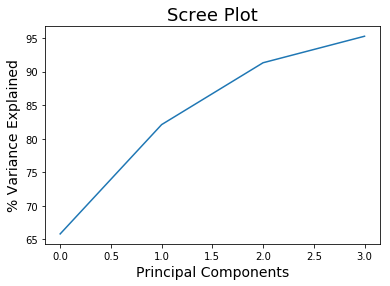

In [81]:
# Our dataframe is quite big: With 171 attributes and a little over 21,000 observations we need to reduce dimensionality.
# For this task, we will use PCA for our explanatory variables, excluding our response variable. 
# We will use pca.transform to create a new X that contains only 5 principal components, and which will be used in 
# logistic regression.

from sklearn.decomposition import PCA
pca = PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)
pca.fit(X)
X = pca.transform(X) # Create a matrix X that contains the  first 5 principal components of the previous X (df_arranged.values)
scree_var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(scree_var)
plt.title('Scree Plot',fontsize = 18)
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('% Variance Explained', fontsize=14)
pca.get_covariance() 

Based on the scree plot, the first principal component (0) explains 67% of the variance, followed by the second (1) explaining 82%; the third (2) explaining 92%, while the fourth (3) explains about 95%. 

<h3><b> Training and Testing Split</b></h3>

After reducing the dimensions of our explanatory variables (X) data into four principal components (X_pca), we will split the data into a training set, containing 80% of the data, and a test set containing the remaining 20%. Since we would like to make sure that the subgroups of data that will be split into training and testing are not only random but proportional.

We will choose a cross-validation with 10 folds as it will provide better estimate of the error, and it will helps us determine the predictive power of our model. 

In [82]:
# Set cross-validation parameters, which is what we will use to determine the predictve power of our model.
num_cv_iterations = 10 # we ara choosing 10 folds because it provides the best estimate of error.
num_instances = len(y)

# Now split data into Training (80%) and Test (20%) data sets

cv_object = StratifiedShuffleSplit(n_splits = num_cv_iterations, test_size = 0.2) # we use stratified to make sure that 
# train and test data contains important information on both

print(cv_object)



StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None)


<h3><b> Logistic Regression </b></h3>

By creating a logistic regression object named "lr_clf" we will be able to fit our training data, which will be now strored in new variables: X_train containing our four chosen components as the explanatory variable and y_train containing the response variable, and use the test data, also contained in new variables: X_test (explanatory) and y_test (response), which we will use to predict by creating an object called y_hat.

Also, we will use the test response variable y_test and the object y_hat to calculate the accuracy score and the confusion matrices based on the 10 folds that we selected for the cross validation object called cv_object. 

In [83]:

from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Create logistic regrssion object
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) #We will start with a ost of 1.0 and then compare
# with a model with a lower cost later on

#We decided to use this code from notebook 04 because it is clear what it does, and how it does it. 
iter_num=0 
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)  # here we use our train data to fit the logistic regression
    y_hat = lr_clf.predict(X_test) # and we use test data to predict

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    

====Iteration 0  ====
accuracy 0.924225028703
confusion matrix
 [[4021    9]
 [ 321    4]]
====Iteration 1  ====
accuracy 0.925373134328
confusion matrix
 [[4026    4]
 [ 321    4]]
====Iteration 2  ====
accuracy 0.922847301952
confusion matrix
 [[4018   12]
 [ 324    1]]
====Iteration 3  ====
accuracy 0.923765786452
confusion matrix
 [[4020   10]
 [ 322    3]]
====Iteration 4  ====
accuracy 0.923536165327
confusion matrix
 [[4018   12]
 [ 321    4]]
====Iteration 5  ====
accuracy 0.923536165327
confusion matrix
 [[4019   11]
 [ 322    3]]
====Iteration 6  ====
accuracy 0.924684270953
confusion matrix
 [[4024    6]
 [ 322    3]]
====Iteration 7  ====
accuracy 0.924684270953
confusion matrix
 [[4022    8]
 [ 320    5]]
====Iteration 8  ====
accuracy 0.924454649828
confusion matrix
 [[4025    5]
 [ 324    1]]
====Iteration 9  ====
accuracy 0.923765786452
confusion matrix
 [[4021    9]
 [ 323    2]]


The accuracy of the 10 different models ranges from 92.1% - 92.4%, which is to be expected considering that our response variable is unbalanced with 92.5% (20,146 instances) of the data corresponding to class 0 and only 7.5% (1,627 instances) corresponding to class 1. 

<h3><b> Parameters changed in model </b></h3>

In [84]:
#Set regularization parameter
for i, C in enumerate((100, 1, 0.01)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X_train,y_train)
    clf_l2_LR.fit(X_train,y_train)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.2f" % C)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X_train,y_train))
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X_train,y_train))
    
    y_hat_l1 = clf_l1_LR.predict(X_test)
    y_hat_l2 = clf_l2_LR.predict(X_test)
    
    acc = mt.accuracy_score(y_test,y_hat_l1)
    conf = mt.confusion_matrix(y_test,y_hat_l1)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    
    acc = mt.accuracy_score(y_test,y_hat_l2)
    conf = mt.confusion_matrix(y_test,y_hat_l2)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)

C=100.00
Sparsity with L1 penalty: 0.00%
score with L1 penalty: 0.9246
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.9246
====Iteration 10  ====
accuracy 0.923765786452
confusion matrix
 [[4021    9]
 [ 323    2]]
====Iteration 10  ====
accuracy 0.923765786452
confusion matrix
 [[4021    9]
 [ 323    2]]
C=1.00
Sparsity with L1 penalty: 0.00%
score with L1 penalty: 0.9246
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.9246
====Iteration 10  ====
accuracy 0.923765786452
confusion matrix
 [[4021    9]
 [ 323    2]]
====Iteration 10  ====
accuracy 0.923765786452
confusion matrix
 [[4021    9]
 [ 323    2]]
C=0.01
Sparsity with L1 penalty: 25.00%
score with L1 penalty: 0.9247
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.9246
====Iteration 10  ====
accuracy 0.923765786452
confusion matrix
 [[4021    9]
 [ 323    2]]
====Iteration 10  ====
accuracy 0.923765786452
confusion matrix
 [[4021    9]
 [ 323    2]]


 ##### Switching to the l2 penalty yields greater sparsity without a reduction in the predicitve power of the model.

In [94]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd
from sklearn.model_selection import cross_val_score

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)


[ 0.92330654  0.92491389  0.92514351  0.92399541  0.9228473   0.92537313
  0.9228473   0.92468427  0.92376579  0.92422503]


<h3><b> Suppor Vector Machine </b></h3>

In [86]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

accuracy: 0.925373134328
[[4030    0]
 [ 325    0]]
(4114, 4)
(4114,)
[2812 1302]


#### Accuracy not materially improved on our data set.

<h3><b>[10 points]</b>

<i>Discuss the advantages of each model for each classification task. Does one type
of model offer superior performance over another in terms of prediction accuracy? In terms of
training time or efficiency? Explain in detail.</i>



Understanding the differences between theoretical statistical procedures and SVM helps to determine the advantages and disadvantages, and both are dependent on the type of data to be modeled.  Real-world, statistical methods usually rely on scientifically based statistical procedures (Anguita, Ghio, Greco, Oneto, & Ridella).  These methods split the data into a training dataset and a hold-out set.  The training set it used to create a model, while the hold-out set is used for computing the generalization error estimation (Anguita, Et. Al.).  As stable as these practical methods are, they tend to find a separating hyperplane, but not usually an optimal one (Berwick).

SVM MLT’s goal is to maximize the margin around the separating hyperplane (Berwick).  The “support vectors are the elements of the training set that would change the position of the dividing hyperplane if removed” (Berlick). In a post on Stack Exchange, Gavin Simpson outlines a few advantages and disadvantages of SVM.  One not so significant advantage he points out is a simple one, that SVM has a “regularization parameter” that assists the user to avoid over-fitting.  He also believes that since it uses the “kernel trick” it can build in expert knowledge about a problem using by engineering the kernel (Simpson).

Although, SVM has a learning phase that finds a set of parameters by using quadratic programming, usually the search for the most optimal parameters does not complete and additional tuning must be done (Anguita, Et. Al.).  Using optimization techniques, such as Lagrange multipliers, can aid to get the data into an arrangement that can be solved analytically (Berwick).  Simpson noted one disadvantages is that the SVM theory only covers the “determination of the parameters for a given value of the regularization and kernel parameters and choice of kernel”.

There doesn’t seem to be much difference in performance based on the information provided, and we believe it is dependent on the imbalance prevalent on our response variable (y), where the difference in the number of instances between class 0 and class 1 are important considering that class 0 holds about 92.5% of the data. This imbalance definitely influenced the accuracy scores, particularly when there was no cost set for any missclassification of false negatives or positives. Now we know that we could have prevented this by creating a cost matrix in which we can assign lower costs to the true positive, a higher cost to those false negatives, and lower but positive cost to the false positives, and then multiply it by the each of the confusion matrices. That way we could obtain a more reliable and realistic accuracy score regarding the number of people that were reported as dead when they did not die in an accident and vice versa. 

If we were to base our model decision on the accuracy scores retrieved by either the logistic regression or the SVM, this will be a difficult task because the range of accuracy scores of the logistic regression with 10 fold cross-validation was from 92.1% - 92.4%, while the accuracy retrieved by SVM achieved a 92.5%. There is just 1% difference between the highest end of the range of logistic regression models and SVM, but a 1% could mean a world of difference when it comes to prediction. 

Now, based on the confusion matrices provided by each of the models, in which SVM returned one where there were no false negatives due to the imbalance of the data which cause a high sensitivity in which no cost was assigned to the false positives, and based on this the logistic regression seem as a more efficient model. 


In terms of training time and efficiency, SVM seems a much more complicated model because it involves transforming the data and the use of kernels and also because perhaps because we are more familiar with logistic regression which we have seen previously but at the end of the day, if the data is cleaned, and correctly splitted into training and testing sets, both models represent an efficient way to classify data. 

Although 

In our case, the dimensionality reduction of the data using PCA represented a challenge regarding the correct interpretation of the data considering that python does not provide a covariance matrix in which we could have detected which attributes had a higher covariance in each of the components.

There was more of a difference within the model by choosing one parameter (cost) over another.  We observed that the lower the cost, the higher the accuracy.  This makes sense because C is the “penalty on the slack variables which measure the degree to which the margin constraints are violated” (Chin).  For our data, there wasn’t a significant difference.  It is more beneficial to look within the regression model and fine tune it rather than use SVM.

Our data illustrates what Edwin Chin stated on his blog, “better data often beats better algorithms”.  That holds true for our data set which is why both models performed well.   




at  Even though the metric of accuracy does not contemplates the cost of missclassifying false negatives and false positives, both the logistic regression models and the SVM returned an accuracy score that is quite similar

Resources:

Anguita, D., Ghio, A., Greco, N., Oneto, L., & Ridella, S. Model Selection for Support Vector Machines: Advantages and Disadvantages of the Machine Learning Theory.  Smartlab.  http://www.smartlab.ws/files/pubblications/ICP/AngGhiRid_IJCNN10.pdf.  Accessed June 18, 2017.

Berwick, R. An idiot’s guide to Support vector machines (SVMs).  Village Idiot.  http://www.svms.org/tutorials/Berwick2003.pdf.  Accessed June 18, 2017

Chin, E.  Edwin Chin Blog.  http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier.  Accessed June 18, 2017.

Simpson, G.  Stack Exchange Blog Post.  May 2, 2014.  https://stats.stackexchange.com/questions/24437/advantages-and-disadvantages-of-svm.  Accessed June 18, 2017.

Marsupial, D.  Stack Exchange Blog Discussion.  Cross Validated.  “SVM: Why does the number of support vectors decrease when C is increased?” https://stats.stackexchange.com/questions/270187/svm-why-does-the-number-of-support-vectors-decrease-when-c-is-increased.  Accessed June 18, 2017.


<h3><b>[30 points]</b>

<i>Use the weights from logistic regression to interpret the importance of different
features for the classification task. Explain your interpretation in detail. Why do you think
some variables are more important?</i></h3>

Considering that we reduced the dimensionality of our dataframe "df_arranged" using PCA selecting only five principal components that later were used to split data into training and test sets, which in turn were used to pass through the logistic regression object, it seems adequate to calculate the weights of those five components that are now part of the train set (X_train) in order to decide if all of them are worth keeping and if their presence do not cause an overfitting of the model. 


In [90]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T 
variable_names = X_train
for coef, name in zip(weights,variable_names):
    print(name, 'This principal component from the training data has weight of', coef[0])
    


[-5.34418077 -8.09625071 -4.50701903  1.56495696] This principal component from the training data has weight of 0.0650377084484
[ 17.45764237  12.41880561   6.60591012   2.22248572] This principal component from the training data has weight of 0.0154477597284
[-1.96034614 -7.30178685  5.62585816 -2.64923759] This principal component from the training data has weight of -0.00157791612436
[ 29.2995645    1.41928788   6.18967858  -2.69939921] This principal component from the training data has weight of 0.604316844227


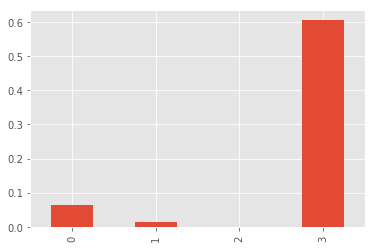

In [89]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0])
weights.plot(kind='bar')
plt.show()

<ul>
  <li>The first component identified with the number 0 has a weight of:  0.0650377084484</li>
  <li>The second component identified with the number 1 has a weight of: 0.0154477597284</li>
  <li>The third component identified with the number 2 has a weight of: -0.00157791612436</li>
  <li>The fourth component identified with the number 3 has a weight of: 0.604316844227</li>
</ul>

The first two components (0 and 1) and the last one (3)--also the "heaviest" one with a weight of 0.604316844227--  are positively correlated. The second component has a negative weight of -0.00157791612436 (for that reason it is not displayed on the graph), which makes it the "lighest" one and the only one that is negatively correlated to the rest. (It is beyond our understanding why the plot is only showing positive weight values.)


Regarding component 0, which array of values is [-5.34418077 -8.09625071 -4.50701903  1.56495696], we can definitely notice that the first three elements are negatively correlated, being -4.50701903 the highest negative loading, while the fourth element possesses the highest positive loading of 1.56495696.

For component 1, which array of values is [ 17.45764237  12.41880561   6.60591012   2.22248572], we can see that all of the elements are positively correlated with the first two elements displaying the highest loadings at 17.45764237 and 12.41880561. 

For component 2, which array of values is [-1.96034614 -7.30178685  5.62585816 -2.64923759], we see something similar to component 0 where three out four elements are negatively correlated, although in this case the highest negative loading is even greater at -2.64923759 than that of component 0, which was of -4.50701903. The highest positive loading is located on the third element with 5.62585816.

Finally, for component 3, which array of values is [ 29.2995645    1.41928788   6.18967858  -2.69939921]. Just by looking at the loadings it is easy to understand why this component is the heaviest one not only because three of its elements are positive while only one is negative, but because the first element displays the highest loading of all of the components with a value of 29.2995645. Definitely this first element is responsible for the total weight of the component itself. 

Although PCA itself standardizes the data, we would like to see if "normalizing" the components of the training set creates a change that could be benefitial by scaling the four components to see if the third, and heaviest, could become more similar in its weight to the rest. 


In [92]:
from sklearn.preprocessing import StandardScaler

# Normalization


# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 


X_train_scaled = scl_obj.transform(X_train) 
X_test_scaled = scl_obj.transform(X_test) 

# train the model 
lr_clf = LogisticRegression(penalty='l2', C=0.05) 
lr_clf.fit(X_train_scaled,y_train)  

# get test set precitions
y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and display results
zip_vars = zip(lr_clf.coef_.T,X_train) 
for coef, name in zip_vars:
    print(name, 'This component has a weight of', coef[0]) 

accuracy: 0.923765786452
[[4021    9]
 [ 323    2]]
[-5.34418077 -8.09625071 -4.50701903  1.56495696] This component has a weight of 0.0650377084484
[ 17.45764237  12.41880561   6.60591012   2.22248572] This component has a weight of 0.0154477597284
[-1.96034614 -7.30178685  5.62585816 -2.64923759] This component has a weight of -0.00157791612436
[ 29.2995645    1.41928788   6.18967858  -2.69939921] This component has a weight of 0.604316844227


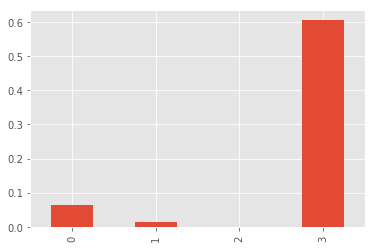

In [93]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0])
weights.plot(kind='bar')
plt.show()

Normalization did not at all affect the weights of any of the components or the values of their loadings. They remained untouched, after which we can conclude that by far component 3 is the strongest of them all. 

The only component we would eliminate is component 2 not because it is negatively correlated but because at -0.00157791612436 its correlation is not as strong in comparison to the rest. 

<h3><b>[10 points]</b>

<i>Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain. If you used stochastic gradient descent (and therefore did
not explicitly solve for support vectors), try subsampling your data to train the SVC model—
then analyze the support vectors from the subsampled dataset.</i>

Due to the accuracy of our prediction, and the fact that we didn’t have too large of a data set, we did not feel we needed to use stochastic gradient descent.  In addition, we were not adding data to our training set, but gradient descent could be used if we were. 

Looking at the output of SVM, we have 3919 support vectors for the five components (which resulted from PCA); 2617 and 1302 in each class.  These support vectors lie on the margin.  A couple of insights we can glean from this information is that our data is linearly separable with a large margin.  

(3919, 5)
(3919,)
[2617 1302]
